# Preprocessing for Nitrogen Loading Model (Nload)

## Objectives

Within subwatersheds of the Wareham (Agawam) reclassify Massachusetts 2016 land cover layer to include cranberry agriculture into 13 categories for use in Nload. Repeat this for baseline conditions, and several scenarios.

Future scenarios could include increasing population and impervious area by displacing natural areas. Growth of cranberry agriculture in uplands with modern cranbery hybrids. Retirement and/or restoration of older and flowthrough bogs. Replacement of older flowthrough bogs with new hybdrids. Upgrades to wastewater treatment facilities. 


Delineate the terminus zone of each subwatershed then calculate the terminus transmission coefficent based on land use within the terminus. The input data for terminus is a lidar DEM, and NRCS hydrologic soil group (available from MassGIS). 

We define the terminus as the area within each subwatershed where groundwater converges, interact with the surface water then, infiltrates and diverges. This commonly occurs in kettle-hole ponds but also occurs in bogs and other depression zones (figure 3 below). Subdrainages have been deliniated for several aquifers in southeastern massachusetts using MODFLOW groundwater simulation software (Walter & Masterson 2011).

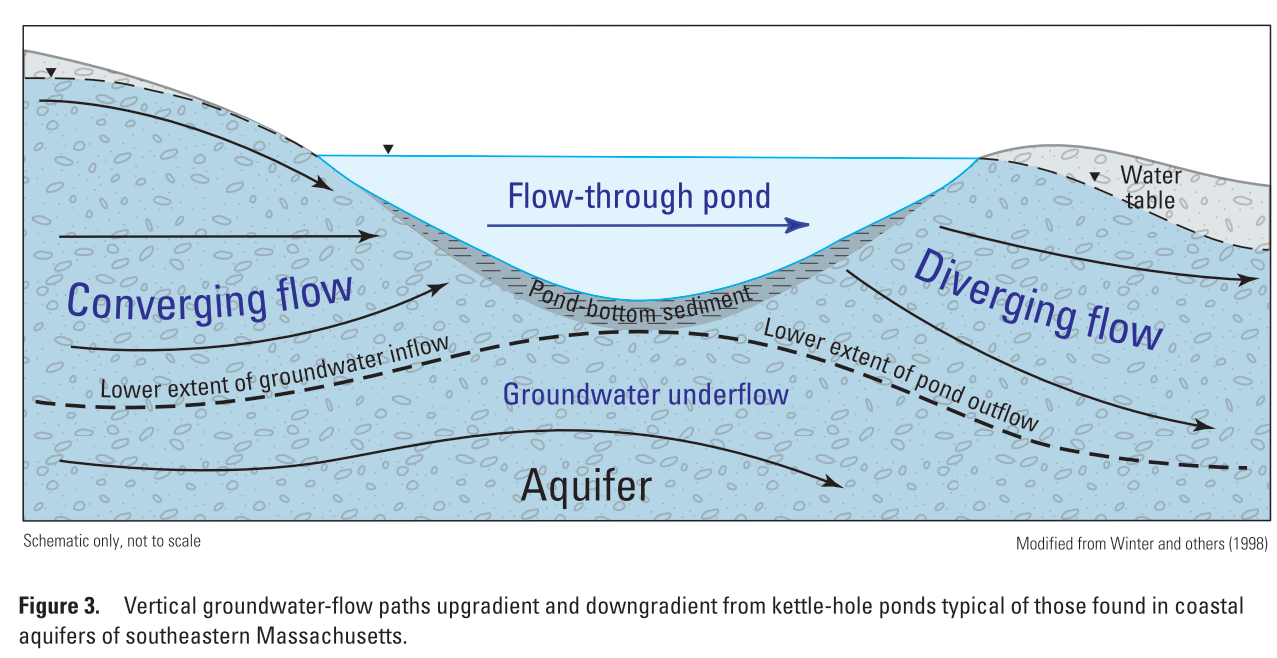


Accordingly, the terminus zone is defined using GIS software using the following critera:
1. Areas at or below the bottom 5th percentile of elevation subdrainage
2. Either:
    
    a. Areas with very poorly drained soils
    b. hydrologic soil groups (D, A/D, B/D, C/D)
    c. water table depth < 8" 
    b. AND OR Surface water bodies


## References 
Kennedy, C. D., & Hoekstra, B. R. (2021). Measuring and modeling nitrogen export from cranberry farms. Ecosphere, 12(12), 1–15. https://doi.org/10.1002/ecs2.3686

Valiela, I., Geist, M., McClelland, J., & Tomasky, G. (2000). Nitrogen loading from watersheds to estuaries: Verification of the Waquoit Bay Nitrogen Loading Model. Biogeochemistry, 49(3), 277–293. https://doi.org/10.1023/A:1006345024374

Valiela, I., Collins, G., Kremer, J., Lajtha, K., Geist, M., Seely, B., … Sham, C. H. (1997). Nitrogen loading from coastal watersheds to receiving estuaries: New method and application. Ecological Applications, 7(2), 358–380. https://doi.org/10.1890/1051-0761(1997)007[0358:NLFCWT]2.0.CO;2

Walter, D. A., & Masterson, J. P. (2011). Estimated hydrologic budgets of kettle-hole ponds in coastal aquifers of southeastern Massachusetts. http://pubs.usgs.gov/sir/2011/5137/
## Set up environment

In [1]:
# Load dependancies ***************************************
import arcpy as ap
import os, glob, re, sys
import pandas as pd
import numpy as np
#import scipy.stats

# Set up arcpy environment ******************************
# input data directory
idr = "C:\\Workspace\\Geodata\\Massachusetts\\"
# working directory this should be where arcgis project is located
wdr = "C:\\Workspace\\Geodata\\Nload\\"
# output directory
odr = os.path.join(wdr,'outputs')
# arcpy settings
ap.env.workspace = wdr # set arcpy environment working directory
aprx = arcpy.mp.ArcGISProject("Current") # current project
ap.CheckOutExtension("Spatial") # check out spatial extension
ap.env.outputCoordinateSystem = arcpy.SpatialReference("NAD 1983 UTM Zone 19N") # define cordinate system
# Allow overwriting of output
arcpy.env.overwriteOutput = True
#ap.SetProgressor("step", "processing...", step_value = 5)

Tip: see this [page](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/setprogressor.htm) for tips on arcpy settings. 

Tip: Use `os.path.join` to safely concatenate file paths. To do this enter folder names in quotes separated by commas.

Tip: Test in the geoprocessing tab first, then, once working, can copy python code from the geoprocessing tab when you click on the arrow next to `run`!

In [4]:
# check that directories exist
if os.path.exists(wdr) is False:
    sys.exit(wdr+" does not exist")
if os.path.exists(idr) is False:
    sys.exit(idr+" does not exist")
if os.path.exists(odr):
    print(odr+" already exists")
else:
    os.mkdir(odr)

C:\Workspace\Geodata\Nload\outputs already exists


Tip: Use `arcpy.FeatureSet` to add an input feature as an object to the current environment. Alternatively, `arcpy.management.MakeFeatureLayer` can be used to add input feature as a layer to the current project. The added layer should appear on the map. `arcpy.Copyfeatures_management` works in a similar way to `MakeFeatureLayer`. 

## Load input files

In [6]:
# Add Input Data *********************************** 
# Massachusetts 2016 Land Use Land Cover Layer 
path = os.path.join(idr,"lclu_gdb","MA_LCLU2016.gdb","LANDCOVER_LANDUSE_POLY")
MA_LCLU2016 = ap.FeatureSet(path)
ap.management.MakeFeatureLayer(path,"in_lclu16")

# Massachusetts cranberry agriculture (source: Jim McLaughlin)
# this needs to be updated
path = os.path.join(idr,'WMAbogsDRAFT2013\\WMAbogsDRAFT2013.shp')
os.path.exists(path)
arcpy.CopyFeatures_management(path,"in_bogs")
bogs = ap.FeatureSet(path)
#ap.management.MakeFeatureLayer(path, "lyr_ggbp")
path = os.path.join(idr,'Wareham_Bogs_v3\\WarehamBogs_master_v3.shp')
os.path.exists(path)
arcpy.CopyFeatures_management(path,"in_wareham_bogs")
wareham_bogs = ap.FeatureSet(path)

# Subcatchments of Agawam (Wareham) with terminus classifications
path = os.path.join(idr,"agawam_WS","agawam_subw_0309.shp")
agawam = ap.FeatureSet(path)
ap.management.MakeFeatureLayer(path,"in_agawam")

# Subcatchments of Great, Green, and Bourne Ponds with terminus classifications
path = os.path.join(idr,"GGBsheds","Great_Green_Bourne_Ponds.shp")
os.path.exists(path)
ggbp = ap.FeatureSet(path)
ap.management.MakeFeatureLayer(path,"in_ggbp")

<Result 'in_ggbp'>

## Main Program

### Part 1: Combine spatial layers

`arcpy.analysis.Intersect` (A) land use and (B) subwatershed Layer. 

In [7]:
# Intersect MA land use layer with subwatershed layer
inFeatures = [MA_LCLU2016, agawam]

In [8]:
intersectOutput = "out_agawam_lclu16"

In [9]:
arcpy.analysis.Intersect(inFeatures, intersectOutput, "", "", "INPUT")

<Result 'C:\\Workspace\\Geodata\\Nload\\out_agawam_lclu16.shp'>

Spatial (A) join cranberry and (B) intersection of subwatershed land use layers. 

In [10]:
# change FID as BOG_FID in attribute table
arcpy.management.CalculateField("in_wareham_bogs","BOG_FID","!FID!", 
                                "PYTHON3",'',"TEXT","NO_ENFORCE_DOMAINS")
                                

<Result 'in_wareham_bogs'>

In [11]:
inFeat = intersectOutput
identFeat = "in_wareham_bogs"
identOutput = "out_lclu16_agawam_cran_ident"

In [12]:
arcpy.analysis.Identity(inFeat, identFeat, identOutput, "ALL", None, "NO_RELATIONSHIPS")

<Result 'C:\\Workspace\\Geodata\\Nload\\out_lclu16_agawam_cran_ident.shp'>

Calculate area of polygons in hectares and export attribute tables to pandas dataframe

In [364]:
def fn_Calculate_Area_Ha(fc):
    # calculate area in hectares and add column to attribute table
    arcpy.management.CalculateGeometryAttributes(fc,
                                             "Area_Ha AREA_GEODESIC",
                                             '', "HECTARES", None, "SAME_AS_INPUT")

# path to feature class
fc1 = "in_agawam"
fn_Calculate_Area_Ha(fc1)

In [365]:
fc2 = identOutput
fn_Calculate_Area_Ha(fc2)

In [15]:
def fn_featureClass_Attributes_to_DataFrame(fc):
    # list of field names that excludes the shape geometry (including geometry messes this up)
    flds = [fld.name for fld in arcpy.ListFields(fc) if fld.name != arcpy.Describe(fc).shapeFieldName]
    arr = arcpy.da.FeatureClassToNumPyArray(fc,flds)
    df = pd.DataFrame(arr)
    return(df)

in_df1 = fn_featureClass_Attributes_to_DataFrame(fc1).rename(columns={'SHED_ID':'SUB','Terminal_N':'Terminus'})

In [16]:
in_df2 = fn_featureClass_Attributes_to_DataFrame(fc2).rename(columns={'SHED_ID':'SUB','Terminal_N':'Terminus'})

In [17]:
# check that area of the inputs and outputs match closely
Total_Area1 = in_df1.Area_Ha.sum()
Total_Area2 = in_df2.Area_Ha.sum()
print(fc1+" Area (Ha):"+str(Total_Area1))
print(fc2+" Area (Ha):"+str(Total_Area2))
print("Difference in Area:"+str(Total_Area1 - Total_Area2)) # difference should be close to 0.0

in_agawam Area (Ha):12009.71311226879
out_lclu16_agawam_cran_ident Area (Ha):12007.009466206888
Difference in Area:2.7036460619019635


In [19]:
# write attribute tables to csv
in_df1.to_csv(os.path.join(odr,fc1+".csv"))
in_df2.to_csv(os.path.join(odr,fc2+".csv"))

In [359]:
# add csv to the map with content manager
import arcgis 


#from arcgis.features import SpatialDataFrame
#lyr2 = ap.FeatureSet(fc2)
#sdf2 = SpatialDataFrame.from_layer(lyr2)
#print(fc2)
#lyr2 = arcpy.management.MakeFeatureLayer(fc2)
#sdf2 = SpatialDataFrame.from_layer(lyr2)
aprx = arcpy.mp.ArcGISProject('current')

#print(l)
#print(lyr2)
for m in aprx.listMaps():
    print("Map: {0} Layers".format(m.name))
    i = 0
    for lyr in m.listLayers():
        if lyr.isBroken:
            print(str(i)+" (BROKEN) " + lyr.name)
        else:
            print(str(i)+"   " + lyr.name)
        i = i + 1
     
m = p.listMaps()[0]
l = m.listLayers()
sdf2 = pd.DataFrame.spatial.from_layer(l[0])

Map: Map Layers
0   out_lclu16_agawam_cran_ident
1   in_agawam
2   out_agawam_lclu16
3   in_ggbp
4   in_wareham_bogs
5   in_bogs
6   in_lclu16
7   out_wareham_bogs_Identity
8   in_wareham_bogs_Identity
9   prj_wareham_bogs
10   Graphics Layer
11   Hybrid Reference Layer
12   NHD_Southeast_Mass
13   HYDRO_NET_Junctions
14   NHDPoint
15   NHDPointEventFC
16   NHDFlowline
17   NHDLine
18   NHDLineEventFC
19   NHDArea
20   NHDAreaEventFC
21   NHDWaterbody
22   FEMA_NFHL_POLY
23   World Imagery


Exception: Could not load the dataset: 'Layer' object has no attribute 'filter'

### Part 1: Reclassify combined layers for Nload Scenarios

Read excel tables with subwatershed land use area and terminus information

In [356]:

# Subwatershed land use area
inname1 = "in_agawam"
inname2 = "out_lclu16_agawam_cran_ident"
in_df1 = pd.read_csv(os.path.join(odr,inname1+'.csv')).rename(columns={'SHED_ID':'SUB','Terminal_N':'Terminus'})

# Subwatershed catchment ids and terminus information
in_df2 = pd.read_csv(os.path.join(odr,inname2+'.csv')).rename(columns={'SHED_ID':'SUB','Terminal_N':'Terminus'})

In [357]:
display(in_df1)
display(in_df2)

,Unnamed: 0,FID,sf_area,SubWat_Num,New_ID,ft_perim,SubW_Names,SUB,Terminus,F_,Area_Ha
0,0,0,3.471427e+07,0,0,65465.877695,Estuary,0,e,0.0,322.510995
1,1,1,7.005651e+07,2,2,110369.417469,Agawam Reservoir S LT10,2,p,0.0,650.865795
2,2,2,2.110986e+06,19,19,8946.781816,Fearing Pond GT10,19,p,0.0,19.612364
3,3,3,1.227794e+07,21,21,17597.201223,Fearing Pond LT10,21,p,0.0,114.069335
4,4,4,6.956152e+06,24,24,17478.938892,Little Long Pond GT10,24,p,0.0,64.626888
5,5,5,1.361948e+07,25,25,22761.742210,Little Long Pond LT10,25,p,0.0,126.532533
6,6,6,4.162610e+06,22,22,9198.367018,Abner Pond,22,p,0.0,38.672989
7,7,7,6.418631e+06,23,23,13775.354863,Five Mile Pond,23,p,0.0,59.632582
8,8,8,2.098890e+07,26,26,32094.470678,East Branch N,26,s,0.0,194.998012
9,9,9,1.078122e+07,30,30,18422.485411,Charge Pond LT10,30,p,0.0,100.163457


,Unnamed: 0,FID,FID_out_ag,FID_LANDCO,COVERNAME,COVERCODE,USEGENNAME,USEGENCODE,USE_CODE,POLY_TYPE,FY,TOWN_ID,TILENAME,Shape_Leng,Shape_Area,FID_agawam,sf_area,SubWat_Num,New_ID,ft_perim,SubW_Names,SUB,Terminus,F_,Area_Ha,FID_in_war,WMA_NO,OWNER,ADDRESS,TOWN,REGION,BOG_NAME,STAFF,PROGRAM,DATE_ENTER,COMMENT,BIRTHREG,PERMIT_NUM,CropStatus,Bog_Code,Bog_Name_2,Active,Plant_Year,Variety,Var_Class,Bog_type,Area_sqft,Area_ha_1,renovated,ren_yr,new_upland,new_yr,New_ID_1,SubW_Nam_1,Basin_1,BOG_FID
0,0,0,0,17132259,Impervious,2,Unknown,0,000,FEE,2016,310,R12C23,358.492424,989.500000,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.098950,-1,,,,,0,,,,1899-12-30,,,,,,,,,,,,0.0,0.00000,,,,,0,,,
1,1,1,1,17132780,Grassland,8,Unknown,0,000,FEE,2016,310,R12C23,118.209868,185.792112,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.009283,-1,,,,,0,,,,1899-12-30,,,,,,,,,,,,0.0,0.00000,,,,,0,,,
2,2,2,2,17132840,Evergreen Forest,10,Agriculture,7,7200,FEE,2016,310,R12C23,290.392311,1615.104314,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.161413,-1,,,,,0,,,,1899-12-30,,,,,,,,,,,,0.0,0.00000,,,,,0,,,
3,3,3,3,17132841,Evergreen Forest,10,Agriculture,7,7200,FEE,2016,310,R12C23,2.884870,0.161639,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.000016,-1,,,,,0,,,,1899-12-30,,,,,,,,,,,,0.0,0.00000,,,,,0,,,
4,4,4,4,17132842,Evergreen Forest,10,Agriculture,7,7200,FEE,2016,310,R12C23,47.419592,33.906300,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.003391,-1,,,,,0,,,,1899-12-30,,,,,,,,,,,,0.0,0.00000,,,,,0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114645,114645,114645,97654,17300857,Grassland,8,Agriculture,7,0761,TAX,2016,239,R12C24,645.946789,3629.625000,37,3.800523e+07,33,33,36179.658437,Frogfoot Brook,33,s,0.0,0.001241,241,42431033,A.D. Makepeace Co.,Tihonet Rd.,Plymouth,4,Frog Foot Main,Jim McLaughlin,BRP_WMA,2007-06-18,point 5 (70.72),42431033,9P242431003,active,FR34,,,,EB & H,,flowthrough,679657.0,6.31425,,,,,33,Frogfoot Brook,Wankinco,241
114646,114646,114646,97771,17301726,Deciduous Forest,9,Agriculture,7,0761,TAX,2016,239,R12C24,121.932504,554.625000,37,3.800523e+07,33,33,36179.658437,Frogfoot Brook,33,s,0.0,0.008807,241,42431033,A.D. Makepeace Co.,Tihonet Rd.,Plymouth,4,Frog Foot Main,Jim McLaughlin,BRP_WMA,2007-06-18,point 5 (70.72),42431033,9P242431003,active,FR34,,,,EB & H,,flowthrough,679657.0,6.31425,,,,,33,Frogfoot Brook,Wankinco,241
114647,114647,114647,97904,17302602,Palustrine Forested Wetland,13,Agriculture,7,0761,TAX,2016,239,R12C24,269.178716,1873.000000,37,3.800523e+07,33,33,36179.658437,Frogfoot Brook,33,s,0.0,0.012413,241,42431033,A.D. Makepeace Co.,Tihonet Rd.,Plymouth,4,Frog Foot Main,Jim McLaughlin,BRP_WMA,2007-06-18,point 5 (70.72),42431033,9P242431003,active,FR34,,,,EB & H,,flowthrough,679657.0,6.31425,,,,,33,Frogfoot Brook,Wankinco,241
114648,114648,114648,109625,17296893,Developed Open Space,5,Tax exempt,9,9570,TAX,2016,310,R12C24,27.749647,41.325427,32,2.052870e+08,20,20,130795.386117,Mill Pond,20,p,0.0,0.004133,-1,,,,,0,,,,1899-12-30,,,,,,,,,,,,0.0,0.00000,,,,,0,,,


In [373]:
# Subwatershed housing units, driveways, septics etcs. 
in_df3 = in_df3 = pd.read_excel(r'C:\Users\Adrian.Wiegman\OneDrive - USDA\Research\Nload\Inputs\Nload_Watershed_Info.xlsx','agawam_info',comment="#")
display(in_df3)

df1 = in_df1[['SUB','SubW_Names','Terminus','Area_Ha']]
df1.SepticUnits = 0
df1 = df1.rename(columns={'SubW_Names':'SubW_Name'})
display(df1)
df1 = df1.merge(in_df3[['SUB','Terminus','SepticUnits']])
print(df1)

,SubW_Name,SUB,Area_Ha,Terminus,CC7_Ha,CC3_Ha,CC2_Ha,People_On_Septic,Imp_NR_Ac,NC_cropland_Ac,Unnamed: 10,Buildings,SepticUnits,Unnamed: 13,Unnamed: 14
0,Abner Pond,22,38.672991,p,0.022662,0.000000,0.000000,0.00,0.056,0.000,0.0000,0,0,NaN,NaN
1,Agawam Reservoir N GT10,1,29.389263,p,0.000000,0.000000,0.000000,0.00,0.000,0.000,0.0000,0,0,NaN,NaN
2,Agawam Reservoir N LT10,3,76.512787,p,0.287731,0.000000,0.000000,0.00,0.711,0.000,1.6977,0,0,NaN,NaN
3,Agawam Reservoir S GT10,16,68.226566,p,0.061512,0.000000,0.000000,0.00,0.152,0.000,0.0000,0,0,NaN,NaN
4,Agawam Reservoir S LT10,2,650.865708,p,1.039637,0.000000,0.882579,46.17,2.569,0.000,44.7093,19,19,NaN,NaN
5,Agawam River,42,689.484743,s,72.951466,0.000405,52.629572,2024.19,180.267,0.001,22.9277,1133,833,NaN,NaN
6,Barrett Pond GT10,27,9.675419,p,0.011736,0.000000,0.000000,0.00,0.029,0.000,0.0000,0,0,NaN,NaN
7,Barrett Pond LT10,28,64.189551,p,0.015378,0.000000,0.000000,0.00,0.038,0.000,0.0000,0,0,NaN,NaN
8,bog stream,35,156.183215,s,16.271196,0.000000,2.183221,114.21,40.207,0.000,57.9426,47,47,NaN,NaN
9,Broad Marsh River,43,397.562496,s,62.668809,0.000000,54.719890,1061.91,154.858,0.000,0.0000,1178,437,NaN,NaN


,SUB,SubW_Name,Terminus,Area_Ha
0,0,Estuary,e,322.510995
1,2,Agawam Reservoir S LT10,p,650.865795
2,19,Fearing Pond GT10,p,19.612364
3,21,Fearing Pond LT10,p,114.069335
4,24,Little Long Pond GT10,p,64.626888
5,25,Little Long Pond LT10,p,126.532533
6,22,Abner Pond,p,38.672989
7,23,Five Mile Pond,p,59.632582
8,26,East Branch N,s,194.998012
9,30,Charge Pond LT10,p,100.163457


    SUB                 SubW_Name Terminus      Area_Ha  SepticUnits
0     0                   Estuary        e   322.510995            0
1     2   Agawam Reservoir S LT10        p   650.865795           19
2    19         Fearing Pond GT10        p    19.612364            0
3    21         Fearing Pond LT10        p   114.069335            0
4    24     Little Long Pond GT10        p    64.626888            0
5    25     Little Long Pond LT10        p   126.532533            0
6    22                Abner Pond        p    38.672989            0
7    23            Five Mile Pond        p    59.632582            9
8    26             East Branch N        s   194.998012            0
9    30          Charge Pond LT10        p   100.163457            0
10   28         Barrett Pond LT10        p    64.189598            0
11   29          Charge Pond GT10        p    13.109041            0
12   17       East Head Pond GT10        p   108.155991            0
13   27         Barrett Pond GT10 

Initialize a dataframe for Land cover (LUC) area by Subcatchment (SUB) with values for use class 2 (lawns), 3 (non cranberry ag), 7 (impervous, non-road). 

In [368]:
nLUCs = 13
SUBs =  list(in_df1['SUB'])*nLUCs
print(len(list(in_df1['SUB'])))
LUCs = [i+1 for i in range(nLUCs)]*len(list(in_df1['SUB']))
#print(LUCs)
df_SUB_LUC = pd.DataFrame({"SUB":SUBs,"LUC":LUCs})
df_SUB_LUC
df_SUB_LUC
display(df_SUB_LUC)
df_merged = None
'''
coverclasses = [2,3,7]
for i in coverclasses:
    df_temp = in_df3
    df_temp['LUC'] = i
    df_temp['Area_Ha'] = df_temp['CC'+str(i)+'_Ha']
    df_merged = df_merged.merge(df_temp[['SUB','LUC','Area_Ha']],'left')
display(df_merged)
'''

i = 2
j = 13
df_temp = in_df3
df_temp['LUC'] = i
df_temp['Area_Ha'] = df_temp['CC'+str(i)+'_Ha']
df_merged = df_temp[['SUB','LUC','Area_Ha']]
display(df_merged)
df_temp['LUC'] = j
df_temp['Area_Ha'] = -df_temp['Area_Ha'] 
df_merged = df_merged.merge(df_temp[['SUB','LUC','Area_Ha']],'outer')
display(df_merged)

i = 3 # area to be added
j = 4 # area to be subtracted from 
df_temp = in_df3
df_temp['LUC'] = i
df_temp['Area_Ha'] = df_temp['CC'+str(i)+'_Ha']
df_merged = df_merged.merge(df_temp[['SUB','LUC','Area_Ha']],'outer')
display(df_merged)
df_temp['LUC'] = j
df_temp['Area_Ha'] = -df_temp['Area_Ha'] 
df_merged = df_merged.merge(df_temp[['SUB','LUC','Area_Ha']],'outer')
display(df_merged)

i = 7
j = 6
df_temp = in_df3
df_temp['LUC'] = i
df_temp['Area_Ha'] = df_temp['CC'+str(i)+'_Ha']
df_merged = df_merged.merge(df_temp[['SUB','LUC','Area_Ha']],'outer')
display(df_merged)
df_temp['LUC'] = j
df_temp['Area_Ha'] = -df_temp['Area_Ha'] 
df_merged = df_merged.merge(df_temp[['SUB','LUC','Area_Ha']],'outer')
display(df_merged)

df_SUB_LUC_merged = pd.merge(df_SUB_LUC,df_merged,'left')
display(df_SUB_LUC_merged)
print(len(df_SUB_LUC_merged['SUB'].unique()))
df_SUB_LUC_merged.to_csv("df_SUB_LUC_merged.csv")
print(df_SUB_LUC_merged.sort_values(['LUC','SUB']))

50


,SUB,LUC
0,0,1
1,2,2
2,19,3
3,21,4
4,24,5
...,...,...
645,42,9
646,49,10
647,4,11
648,50,12


,SUB,LUC,Area_Ha
0,22,2,0.000000
1,1,2,0.000000
2,3,2,0.000000
3,16,2,0.000000
4,2,2,0.882579
5,42,2,52.629572
6,27,2,0.000000
7,28,2,0.000000
8,35,2,2.183221
9,43,2,54.719890


,SUB,LUC,Area_Ha
0,22,2,0.000000
1,1,2,0.000000
2,3,2,0.000000
3,16,2,0.000000
4,2,2,0.882579
...,...,...,...
87,31,13,-9.383207
88,32,13,-0.278709
89,45,13,-14.725132
90,47,13,-1.300643


,SUB,LUC,Area_Ha
0,22,2,0.000000
1,1,2,0.000000
2,3,2,0.000000
3,16,2,0.000000
4,2,2,0.882579
...,...,...,...
133,31,3,0.000000
134,32,3,0.000000
135,45,3,0.741384
136,47,3,0.000000


,SUB,LUC,Area_Ha
0,22,2,0.000000
1,1,2,0.000000
2,3,2,0.000000
3,16,2,0.000000
4,2,2,0.882579
...,...,...,...
179,31,4,-0.000000
180,32,4,-0.000000
181,45,4,-0.741384
182,47,4,-0.000000


,SUB,LUC,Area_Ha
0,22,2,0.000000
1,1,2,0.000000
2,3,2,0.000000
3,16,2,0.000000
4,2,2,0.882579
...,...,...,...
225,31,7,8.198931
226,32,7,7.786961
227,45,7,11.391901
228,47,7,1.100340


,SUB,LUC,Area_Ha
0,22,2,0.000000
1,1,2,0.000000
2,3,2,0.000000
3,16,2,0.000000
4,2,2,0.882579
...,...,...,...
271,31,6,-8.198931
272,32,6,-7.786961
273,45,6,-11.391901
274,47,6,-1.100340


,SUB,LUC,Area_Ha
0,0,1,NaN
1,2,2,0.882579
2,19,3,0.000000
3,21,4,-0.000000
4,24,5,NaN
...,...,...,...
645,42,9,NaN
646,49,10,NaN
647,4,11,NaN
648,50,12,NaN


50
     SUB  LUC    Area_Ha
0      0    1        NaN
377    1    1        NaN
351    2    1        NaN
78     3    1        NaN
247    4    1        NaN
..   ...  ...        ...
493   46   13 -16.072226
194   47   13  -1.300643
246   49   13        NaN
298   50   13  -0.000000
649   51   13  -0.696773

[650 rows x 3 columns]


In [460]:
in_df2["ResidentialUnit"] = (in_df2.COVERCODE == 2) & np.isin(in_df2.USEGENCODE,[10,11,12,13])
totalHousingUnits = in_df2['ResidentialUnit'].sum()
df_HU_SUB = in_df2.groupby('SUB')['ResidentialUnit'].sum().reset_index(name='ResUnits')
df_HU_SUB['ResImp_Fraction'] = df_HU_SUB['ResUnits']/totalHousingUnits
display(df_HU_SUB)

totalHousingArea = in_df2.loc[in_df2['ResidentialUnit'], 'Area_Ha'].sum()
df_RIA_SUB = in_df2.loc[in_df2['COVERCODE']==2].groupby('SUB')['Area_Ha'].sum().reset_index(name='Area_Ha')
df_RIA_SUB ['ResImpArea_Fraction'] = df_imp_sub['Area_Ha']/totalImpervious
display(df_RIA_SUB)

,SUB,ResUnits,ResImp_Fraction
0,0,22,0.001793
1,1,7,0.000571
2,2,71,0.005787
3,3,7,0.000571
4,4,49,0.003994
5,5,535,0.043606
6,6,0,0.000000
7,7,35,0.002853
8,8,23,0.001875
9,9,12,0.000978


,SUB,Area_Ha,ResImpArea_Fraction
0,0,0.438803,0.000710
1,1,0.568055,0.000920
2,2,9.127806,0.014778
3,3,3.252814,0.005266
4,4,3.253769,0.005268
5,5,24.751324,0.040072
6,6,0.206291,0.000334
7,7,5.766935,0.009337
8,8,5.321510,0.008615
9,9,1.442824,0.002336


In [375]:
totalImpervious = in_df2.loc[in_df2['COVERCODE']==2, 'Area_Ha'].sum()
df_imp_sub = in_df2.loc[in_df2['COVERCODE']==2].groupby('SUB')['Area_Ha'].sum().reset_index(name='Area_Ha')
df_imp_sub['Impervious_Fraction'] = df_imp_sub['Area_Ha']/totalImpervious

In [426]:
#import numpy as np
#import matplotlib.pyplot as plt 
#from scipy import stats


def fn_round_sig(x, sig=2):
    from math import log10, floor
    return round(x, sig-int(floor(log10(abs(x))))-1)
fn_round_sig(1234243, 3)

1230000

In [461]:
def fn_linreg_plot (x=None,y=None,sig=3):
    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    plt.rcParams.update({'font.sans-serif':'Arial'})
    if x is None:
        print("x not supplied, using default array")
        x = np.array(range(1,20))
    print("x:",x)
    if y is None: 
        print("y not supplied, randomly generating default array based on x")
        y = x + np.random.normal(size=len(x))*np.mean(x)/3
    print("x:",y)   
    lm = stats.linregress(x,y)
    gradient, intercept, r_value, p_value, std_err = lm
    mn=np.min(x)
    mx=np.max(x)
    x1=np.linspace(mn,mx,500)
    y1=gradient*x1+intercept
    plt.plot(x,y,'ob')
    plt.plot(x1,y1,'-r')
    label = "n="+str(len(x))+", r^2="+str(fn_round_sig(r_value,sig))+", p="+str(fn_round_sig(p_value,sig))
    plt.text(x=np.min(x),y=np.max(y)*.99,s=label)
    label = "y = "+str(fn_round_sig(gradient,sig))+"x +"+str(fn_round_sig(intercept,sig))
    plt.text(x=np.min(x),y=np.max(y)*.99-np.max(y)*0.07,s=label)
    plt.show()
    return(lm)
#fn_linreg_plot()

In [27]:
df1['k_Pop'] = None
df1 = pd.merge(df1,df_imp_sub[['SUB','Impervious_Fraction']])
df1 = pd.merge(df1,df_HU_SUB[['SUB','ResUnits']])
df1 = pd.merge(df1,df_RIA_SUB[['SUB','ResImpArea_Fraction']])
# how well do these metrics align
fn_linreg_plot(x=df1.Impervious_Fraction,y=df1.SepticUnits)
fn_linreg_plot(x=df1.ResUnits,y=df1.SepticUnits)
fn_linreg_plot(x=df1.ResImpArea_Fraction,y=df1.SepticUnits)

df1['k_Pop'] = df1.loc[:,'ResImp_Fraction']
display(df1)

NameError: name 'df_imp_sub' is not defined

Reclassify land use using Nload cover codes for default scenario

In [377]:
# GENERATE DICTIONARY OF CONDITIONS FOR RECLASSIFYING LAND USE

# specific active cranberry: where other farming makes up a non zero portion of cultivated and hay/pasture cover types
specific_active_cranberry = '(np.isin(df.CropStatus,"active"))'

# general active cranberry: use where active cranberry makes up over 99% of COVERCODE 6 and 7. 
general_active_cranberry = '((np.isin(df.CropStatus,"active"))|((df.COVERCODE == 21) & (df.USEGENCODE==7))|(np.isin(df.COVERCODE,[6,7])))'

active_cranberry = specific_active_cranberry
abandoned_cranberry = 'np.isin(df["FID"],df[df.CropStatus == "abandoned"]["FID"])'
flowthrough = 'np.isin(df["FID"],df[df.Bog_type == "flowthrough"]["FID"])'
#abandoned_cranberry = '(np.isin(df.CropStatus,"abandoned"))'
#flowthrough = '(np.isin(df.Bog_type,"flowthrough"))'
waterbody = '(np.isin(df.COVERCODE,[22,21]) & np.invert('+active_cranberry+'))'
# condition dictionary
SPECIFIC = {
    # THE FIRST APPEARING CONDITION TAKES PRIORITY IN NP.SELECT
    # key (LUC): value (condition string)
     # 4: "Agriculture, Active Cranberry, Flowthrough"
    4: active_cranberry+' & '+flowthrough,
    # 5: "Agriculture, Active Cranberry, Non Flowthrough"
    5: active_cranberry+' & (np.invert('+flowthrough+'))',
    # 11: "Retired Cranberry, Flowthrough"
    11: abandoned_cranberry+' & '+flowthrough,
    # 12: "Retired Cranberry, Non flowthrough"
    12: abandoned_cranberry+' & np.invert('+flowthrough+')',
    # 1: "Natural Uplands"
    1: '(df.COVERCODE >= 8) & (df.COVERCODE <= 12)',
     # 6: "Impervious, Roads"
    6: '(df.COVERCODE == 2)',
    # 3: "Agriculture, Non Cranberry"
    3: '(np.isin(df.COVERCODE,[6,7])) & (np.invert('+active_cranberry+'))',
    # 8: "Recieving Body (Estuary)"
    8: '(df.SUB == "0") & ((df.COVERCODE == 23)|'+waterbody+')', # note that SUB is a string
    # 9: "Freshwater Ponds and Lakes"
    9: '(df.SUB != "0") &' + waterbody,
    # 10: "Wetlands"
    10: '(df.COVERCODE >= 13) & (df.COVERCODE <= 18)',
    # 2: "Mowed Areas (Lawns, Sports Fields, and Golf Courses)"
    2: 'df.COVERCODE is [False]', # this will be calculated separately
    # 7: "Impervious, Non-Roads"
    7: 'df.COVERCODE is [False]', # this will be calculated separately
    # 13: "Other (Bare land or Shoreline)"
    13: 'df.COVERCODE is [False]'}

GENERAL = {
    # THE FIRST APPEARING CONDITION TAKES PRIORITY IN NP.SELECT
    # key (LUC): value (condition string)
     # 4: "Agriculture, Active Cranberry, Flowthrough"
    4: active_cranberry+' & '+flowthrough,
    # 5: "Agriculture, Active Cranberry, Non Flowthrough"
    5: active_cranberry+' & (np.invert('+flowthrough+'))',
    # 11: "Retired Cranberry, Flowthrough"
    11: abandoned_cranberry+' & '+flowthrough,
    # 12: "Retired Cranberry, Non flowthrough"
    12: abandoned_cranberry+' & np.invert('+flowthrough+')',
    # 1: "Natural Uplands"
    1: 'df.COVERCODE.between(8, 12, inclusive="both")',
     # 6: "Impervious, Roads"
    6: '(df.COVERCODE == 2) & (df.USEGENCODE == 55)',
    ## 3: "Agriculture, Non Cranberry"
    #3: 'df.COVERCODE == [False]',
    # 8: "Recieving Body (Estuary)"
    8: '(df.SUB == "0") & ((df.COVERCODE == 23)|'+waterbody+')', # note that SUB is a string
    # 9: "Freshwater Ponds and Lakes"
    9: '(df.SUB != "0") &' + waterbody,
    # 10: "Wetlands"
    10: 'df.COVERCODE.between(13, 18, inclusive="both")',
    # 2: "Mowed Areas (Lawns, Sports Fields, and Golf Courses)"
    2: 'df.COVERCODE == 5',
    # 7: "Impervious, Non-Roads"
    7: '(df.COVERCODE == 2) & (df.USEGENCODE != 55)',
    # 13: "Other (Bare land or Shoreline)"
    13: 'np.isin(df.COVERCODE,[19,20])'
}

BASELINE = GENERAL    

# checking condtions 
df = pd.DataFrame({"FID":[0,1,2,3],
                   "COVERCODE":[21,21]*2,
                   "SUB":["0","1"]*2,
                   "CropStatus":["active"]*2 + ["abandoned"]*2,
                   "Bog_type":["","flowthrough"]*2,
                   "USEGENCODE":[0,0,0,0],
                   "USE_CODE":[0,0,0,0]})
df = pd.DataFrame({"FID":[4,5,6,7],
                   "COVERCODE":[2,5]*2,
                   "SUB":["0","1"]*2,
                   "CropStatus":[None]*2 + [None]*2,
                   "Bog_type":[None,None]*2,
                   "USEGENCODE":[55,55,0,0],
                   "USE_CODE":[0,0,0,0]})
df = pd.DataFrame({"FID":[8,9,10,11],
                   "COVERCODE":[9,15,19,22],
                   "SUB":["0","1"]*2,
                   "CropStatus":[None]*2 + [None]*2,
                   "Bog_type":[None,None]*2,
                   "USEGENCODE":[55,55,0,0],
                   "USE_CODE":[0,0,0,0]})
df["8"]= eval(BASELINE[8])
df["9"]= eval(BASELINE[9])
df["11"]= eval(BASELINE[11])
df["12"]= eval(BASELINE[12])
df["2"]= eval(BASELINE[2])
df["6"]= eval(BASELINE[6])
df["7"]= eval(BASELINE[7])
df["13"]= eval(BASELINE[13])
df["10"]= eval(BASELINE[10])
df["1"]= eval(BASELINE[1])

condlist = "["+", ".join(list(BASELINE.values()))+"]"
choicelist = list(BASELINE.keys())
df["LUC"] = np.select(eval(condlist),choicelist,13)
print(df)

   FID  COVERCODE SUB CropStatus Bog_type  ...      7     13     10      1  LUC
0    8          9   0       None     None  ...  False  False  False   True    1
1    9         15   1       None     None  ...  False  False   True  False   10
2   10         19   0       None     None  ...  False   True  False  False   13
3   11         22   1       None     None  ...  False  False  False  False    9

[4 rows x 18 columns]


In [10]:
df = in_df2
for i in list(BASELINE.keys()): 
    print("True is in "+str(i)+"....",True in eval(BASELINE[i]))

True is in 4.... True
True is in 5.... True
True is in 11.... False
True is in 12.... True
True is in 1.... True
True is in 6.... True
True is in 8.... True
True is in 9.... True
True is in 10.... True
True is in 2.... True
True is in 7.... True
True is in 13.... True


In [11]:
# declare land use class (LUC) reclasssification function
def fn_reclassify_LUC(df,dictionary,default=13):
    condlist = "["+", ".join(list(dictionary.values()))+"]"
    choicelist = list(dictionary.keys())
    #print(condlist)
    #print(choicelist)
    df["LUC"] =  np.select(eval(condlist),choicelist,default)
    return(df)

In [14]:
# execute reclassification subroutine
df2 = fn_reclassify_LUC(in_df2,BASELINE)
print("Number of LUC == 13:",sum(df2['LUC']==2))
# replace whitespace data with NaN
df2 = df2.replace(r'^\s*$', np.nan, regex=True)
print(df2.columns)
#df2["LUC"] =  np.where(((df2['LUC']==9) & (df2['SUB']==0)),8,df['LUC'])
# sum land area by subcatchment and LUC
def fn_sum_by_sub_and_luc(df_SUB_LUC_Area1,df_SUB_LUC,df_SUB_LUC_Area2):
    print(df_SUB_LUC)
    df2_SUB_LUC_merged = pd.merge(df_SUB_LUC,df_SUB_LUC_Area1,'left')
    print(df_SUB_LUC)
    Area_Ha = df2_SUB_LUC_merged['Area_Ha'].fillna(0) + df_SUB_LUC_Area2['Area_Ha'].fillna(0)
    print(Area_Ha.sum())
    print(len(Area_Ha))
    df_SUB_LUC_AREA = df_SUB_LUC
    df_SUB_LUC_AREA['Area_Ha'] = Area_Ha
    return(df_SUB_LUC_AREA)

df2_SUB_CC_Area = df2.groupby(['SUB','LUC'])['Area_Ha'].sum().reset_index(name='Area_Ha')
print(df2_SUB_CC_Area)
print(df2_SUB_CC_Area.groupby('LUC')['Area_Ha'].sum())
print(df_SUB_LUC)
print(df_SUB_LUC_merged)
df2_i = fn_sum_by_sub_and_luc(df2_SUB_CC_Area,df_SUB_LUC,df_SUB_LUC_merged)
df2_i.to_csv('df2_SUB_CC_Area.csv')
print(df_SUB_LUC)

Number of LUC == 13: 22795
Index(['Unnamed: 0', 'FID', 'FID_out_ag', 'FID_LANDCO', 'COVERNAME',
       'COVERCODE', 'USEGENNAME', 'USEGENCODE', 'USE_CODE', 'POLY_TYPE', 'FY',
       'TOWN_ID', 'TILENAME', 'Shape_Leng', 'Shape_Area', 'FID_agawam',
       'sf_area', 'SubWat_Num', 'New_ID', 'ft_perim', 'SubW_Names', 'SUB',
       'Terminus', 'F_', 'Area_Ha', 'FID_in_war', 'WMA_NO', 'OWNER', 'ADDRESS',
       'TOWN', 'REGION', 'BOG_NAME', 'STAFF', 'PROGRAM', 'DATE_ENTER',
       'COMMENT', 'BIRTHREG', 'PERMIT_NUM', 'CropStatus', 'Bog_Code',
       'Bog_Name_2', 'Active', 'Plant_Year', 'Variety', 'Var_Class',
       'Bog_type', 'Area_sqft', 'Area_ha_1', 'renovated', 'ren_yr',
       'new_upland', 'new_yr', 'New_ID_1', 'SubW_Nam_1', 'Basin_1', 'BOG_FID',
       'LUC'],
      dtype='object')
     SUB  LUC     Area_Ha
0      0    1    0.952013
1      0    2    0.079489
2      0    6    0.002072
3      0    7    0.436730
4      0    9  305.381342
..   ...  ...         ...
334   51    7   10.970

In [15]:
df_SUB_LUC = pd.DataFrame({"SUB":SUBs,"LUC":LUCs})
df_SUB_LUC_merged_general = df_SUB_LUC_merged
df_SUB_LUC_merged_general['Area_Ha'] = 0
print(df_SUB_LUC_merged_general)
df2_i = fn_sum_by_sub_and_luc(df2_SUB_CC_Area,df_SUB_LUC,df_SUB_LUC_merged_general).dropna()
print(df2_i)
# Aggregate Data with Pandas .groupby()
df2_i.to_csv(os.path.join(odr,"Wareham_LUC_Area_general"+".csv"))
display(df2_i)
# check that area is within one tenth of a Ha of input
print('Difference in Total Area (Ha):',round(df2['Area_Ha'].sum() - df2_i['Area_Ha'].sum(),1))

     SUB  LUC  Area_Ha
0      0    1        0
1      2    2        0
2     19    3        0
3     21    4        0
4     24    5        0
..   ...  ...      ...
645   42    9        0
646   49   10        0
647    4   11        0
648   50   12        0
649   51   13        0

[650 rows x 3 columns]
     SUB  LUC
0      0    1
1      2    2
2     19    3
3     21    4
4     24    5
..   ...  ...
645   42    9
646   49   10
647    4   11
648   50   12
649   51   13

[650 rows x 2 columns]
     SUB  LUC
0      0    1
1      2    2
2     19    3
3     21    4
4     24    5
..   ...  ...
645   42    9
646   49   10
647    4   11
648   50   12
649   51   13

[650 rows x 2 columns]
12007.009466206891
650
     SUB  LUC    Area_Ha
0      0    1   0.952013
1      2    2   3.781471
2     19    3   0.000000
3     21    4   0.000000
4     24    5   0.000000
..   ...  ...        ...
645   42    9  77.414554
646   49   10   0.405542
647    4   11   0.000000
648   50   12   0.000000
649   51   13   2.

,SUB,LUC,Area_Ha
0,0,1,0.952013
1,2,2,3.781471
2,19,3,0.000000
3,21,4,0.000000
4,24,5,0.000000
...,...,...,...
645,42,9,77.414554
646,49,10,0.405542
647,4,11,0.000000
648,50,12,0.000000


Difference in Total Area (Ha): -0.0


Reclassify terminus and land use based on cranberry management scenarios

In [16]:
# List of subwatersheds with cranberry at terminus
SUB_LIST_1 = [4, 31, 33, 34, 35, 41]
# List of subwatersheds with flowthrough cranberry at terminus
SUB_LIST_4 = [4, 33, 34]
# List of cranberry bogs at terminus of subwatersheds
BOG_FID_LIST_1 = [307,301,318,295,294,326,310,242,241,259,269,155,156,148,195,194,193,192]
BOG_FID_LIST_1 = [str(i) for i in BOG_FID_LIST_1]
print("total restored area (Ha):",df2[np.isin(df2['BOG_FID'],BOG_FID_LIST_1)]['Area_Ha'].sum())
print(BOG_FID_LIST_1)

total restored area (Ha): 60.71375925858345
['307', '301', '318', '295', '294', '326', '310', '242', '241', '259', '269', '155', '156', '148', '195', '194', '193', '192']


In [18]:
# Dictionary of Scenario Conditions
LUC_scenarios = {
    # 0: "Baseline (Do nothing)"
    0: 'False',
    #1: "Restore Select Bogs to Wetlands"
    1: "np.isin(df2['BOG_FID'],BOG_FID_LIST_1)",
    #2: "Restore All Retired Bogs to Wetlands"
    2: "np.isin(df2['FID'],df2[df2.CropStatus == 'abandoned']['FID'])",
    #3: "Retire All Flowthrough Bogs"
    3: "np.isin(df2['FID'],df2[df2.Bog_type == 'flowthrough']['FID'])",
    #4: "Restore All Flowthrough Bogs to Wetlands"
    4: "np.isin(df2['FID'],df2[df2.Bog_type == 'flowthrough']['FID'])"
}
Terminus_scenarios = {
    # 0: "Baseline (Do nothing)"
    0: '[False]',
    #1: "Restore Select Bogs to Wetlands"
    1: 'np.isin(df1[\'SUB\'],SUB_LIST_1)',
    #2: "Restore All Retired Bogs to Wetlands"
    2: '[False]',
    #3: "Retire All Flowthrough Bogs"
    3: '[False]',
    #4: "Restore All Flowthrough Bogs to Wetlands"
    4: 'np.isin(df1[\'SUB\'],SUB_LIST_4)'
}
#df2 = df2.replace(r'^\s*$', np.nan, regex=True)
#display(df2)
#True in [i is 'abandoned' for i in df2.CropStatus]
Areasum = df2[df2.CropStatus == 'abandoned'].groupby(['SubW_Names','LUC'])['Area_Ha'].sum()
print(Areasum)
print(df2[df2.FID==59495]['CropStatus'] == 'abandoned')
print(df2[df2.FID==114647]['Bog_type'] == 'flowthrough')
#print([i is "abandoned" for i in df2.CropStatus.astype("|S")])
print(df2[['BOG_FID','CropStatus','SUB']].dtypes)
print(eval(LUC_scenarios[2]))
df2.BOG_FID.to_csv("BOG_FID.csv")
print("Is 'True' in the result: ",True in eval(Terminus_scenarios[4]))
Terminus_scenarios.keys()
Terminus_scenarios.values()

SubW_Names           LUC
Agawam River         12     1.470129
Agawam River North   12     1.037043
Crab Cove            12     3.175952
Halfway Pond         12     0.228525
Mill Pond            12     5.810993
Wankinco R N LT10    12     3.670560
Wareham River South  12     0.146782
Wareham River West   12     3.446101
Name: Area_Ha, dtype: float64
59495    True
Name: CropStatus, dtype: bool
114647    True
Name: Bog_type, dtype: bool
BOG_FID       object
CropStatus    object
SUB            int64
dtype: object
[False False False ... False False False]
Is 'True' in the result:  True


dict_values(['[False]', "np.isin(df1['SUB'],SUB_LIST_1)", '[False]', '[False]', "np.isin(df1['SUB'],SUB_LIST_4)"])

In [19]:
# For each scenario reclassify land use, then sum up area by land use and subwatershed
# default value if scenario condition is true
LUC_iftrue = 10
Terminus_iftrue = "w"
scens = [str(i) for i in range(5)]
list(LUC_scenarios.keys())

[0, 1, 2, 3, 4]

In [23]:
# For each scenario reclassify land use,
out_df2 = df2
out_df1 = df1
# switch Terminus of Maple Swamp from w to s
rownums = np.where(out_df1['SubW_Name']=='Maple Swamp')[0]
out_df1.at[rownums,'Terminus']='s'
# default LUC value if scenario condition is true
LUC_iftrue = 10
# default Terminus value
Terminus_iftrue = "w"
for i in list(LUC_scenarios.keys()):
    print (i)
    # alternative land use for scenario 
    if i == 3: 
        LUC_iftrue = 11
    else: 
        LUC_iftrue = 10
        
    # alter LUC based on scenario conditions
    #np.where(logic,if_true, if_false)
    out_df2["LUC"+str(i)] = np.where(eval(LUC_scenarios[i]),LUC_iftrue,df2.LUC)
    sum((np.where(eval(LUC_scenarios[i]),LUC_iftrue,df2.LUC)))
    out_df1["Terminus"+str(i)] = np.where(eval(Terminus_scenarios[i]),Terminus_iftrue,df1.Terminus)
display(out_df2)
display(out_df1)

print(out_df2.groupby('LUC0')['Area_Ha'].sum())
print(out_df2.groupby('LUC1')['Area_Ha'].sum())
print(out_df2.groupby('LUC2')['Area_Ha'].sum())
print(out_df2.groupby('LUC3')['Area_Ha'].sum())
print(out_df2.groupby('LUC4')['Area_Ha'].sum())

#Save the scenario reclassifications to csv
out_path1 = os.path.join(odr,inname1+'_reclass.csv')
out_path2 = os.path.join(odr,inname2+'_reclass.csv')
out_df1.to_csv(out_path1)
out_df2.to_csv(out_path2)

0
1
2
3
4


,Unnamed: 0,FID,FID_out_ag,FID_LANDCO,COVERNAME,COVERCODE,USEGENNAME,USEGENCODE,USE_CODE,POLY_TYPE,FY,TOWN_ID,TILENAME,Shape_Leng,Shape_Area,FID_agawam,sf_area,SubWat_Num,New_ID,ft_perim,SubW_Names,SUB,Terminus,F_,Area_Ha,FID_in_war,WMA_NO,OWNER,ADDRESS,TOWN,REGION,BOG_NAME,STAFF,PROGRAM,DATE_ENTER,COMMENT,BIRTHREG,PERMIT_NUM,CropStatus,Bog_Code,Bog_Name_2,Active,Plant_Year,Variety,Var_Class,Bog_type,Area_sqft,Area_ha_1,renovated,ren_yr,new_upland,new_yr,New_ID_1,SubW_Nam_1,Basin_1,BOG_FID,LUC,LUC0,LUC1,LUC2,LUC3,LUC4
0,0,0,0,17132259,Impervious,2,Unknown,0,000,FEE,2016,310,R12C23,358.492424,989.500000,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.098950,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,7,7,7,7,7,7
1,1,1,1,17132780,Grassland,8,Unknown,0,000,FEE,2016,310,R12C23,118.209868,185.792112,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.009283,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1,1,1,1,1,1
2,2,2,2,17132840,Evergreen Forest,10,Agriculture,7,7200,FEE,2016,310,R12C23,290.392311,1615.104314,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.161413,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1,1,1,1,1,1
3,3,3,3,17132841,Evergreen Forest,10,Agriculture,7,7200,FEE,2016,310,R12C23,2.884870,0.161639,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.000016,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1,1,1,1,1,1
4,4,4,4,17132842,Evergreen Forest,10,Agriculture,7,7200,FEE,2016,310,R12C23,47.419592,33.906300,34,2.475554e+07,40,40,28134.229416,Parker Mills Pond,40,p,0.0,0.003391,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114645,114645,114645,97654,17300857,Grassland,8,Agriculture,7,0761,TAX,2016,239,R12C24,645.946789,3629.625000,37,3.800523e+07,33,33,36179.658437,Frogfoot Brook,33,s,0.0,0.001241,241,42431033,A.D. Makepeace Co.,Tihonet Rd.,Plymouth,4,Frog Foot Main,Jim McLaughlin,BRP_WMA,2007-06-18,point 5 (70.72),42431033,9P242431003,active,FR34,NaN,NaN,NaN,EB & H,NaN,flowthrough,679657.0,6.31425,NaN,NaN,NaN,NaN,33,Frogfoot Brook,Wankinco,241,4,4,10,4,11,10
114646,114646,114646,97771,17301726,Deciduous Forest,9,Agriculture,7,0761,TAX,2016,239,R12C24,121.932504,554.625000,37,3.800523e+07,33,33,36179.658437,Frogfoot Brook,33,s,0.0,0.008807,241,42431033,A.D. Makepeace Co.,Tihonet Rd.,Plymouth,4,Frog Foot Main,Jim McLaughlin,BRP_WMA,2007-06-18,point 5 (70.72),42431033,9P242431003,active,FR34,NaN,NaN,NaN,EB & H,NaN,flowthrough,679657.0,6.31425,NaN,NaN,NaN,NaN,33,Frogfoot Brook,Wankinco,241,4,4,10,4,11,10
114647,114647,114647,97904,17302602,Palustrine Forested Wetland,13,Agriculture,7,0761,TAX,2016,239,R12C24,269.178716,1873.000000,37,3.800523e+07,33,33,36179.658437,Frogfoot Brook,33,s,0.0,0.012413,241,42431033,A.D. Makepeace Co.,Tihonet Rd.,Plymouth,4,Frog Foot Main,Jim McLaughlin,BRP_WMA,2007-06-18,point 5 (70.72),42431033,9P242431003,active,FR34,NaN,NaN,NaN,EB & H,NaN,flowthrough,679657.0,6.31425,NaN,NaN,NaN,NaN,33,Frogfoot Brook,Wankinco,241,4,4,10,4,11,10
114648,114648,114648,109625,17296893,Developed Open Space,5,Tax exempt,9,9570,TAX,2016,310,R12C24,27.749647,41.325427,32,2.052870e+08,20,20,130795.386117,Mill Pond,20,p,0.0,0.004133,-1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00000,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,2,2,2,2,2,2


,SUB,SubW_Name,Terminus,Area_Ha,SepticUnits,Terminus0,Terminus1,Terminus2,Terminus3,Terminus4
0,0,Estuary,e,322.510995,0,e,e,e,e,e
1,2,Agawam Reservoir S LT10,p,650.865795,19,p,p,p,p,p
2,19,Fearing Pond GT10,p,19.612364,0,p,p,p,p,p
3,21,Fearing Pond LT10,p,114.069335,0,p,p,p,p,p
4,24,Little Long Pond GT10,p,64.626888,0,p,p,p,p,p
5,25,Little Long Pond LT10,p,126.532533,0,p,p,p,p,p
6,22,Abner Pond,p,38.672989,0,p,p,p,p,p
7,23,Five Mile Pond,p,59.632582,9,p,p,p,p,p
8,26,East Branch N,s,194.998012,0,s,s,s,s,s
9,30,Charge Pond LT10,p,100.163457,0,p,p,p,p,p


LUC0
1     7930.501797
2      433.396613
4      130.642417
5      550.333431
6      192.111456
7      425.530998
9     1213.857550
10     644.182870
12      18.986086
13     467.466249
Name: Area_Ha, dtype: float64
LUC1
1     7930.501797
2      433.396613
4       99.767703
5      520.494386
6      192.111456
7      425.530998
9     1213.857550
10     704.896629
12      18.986086
13     467.466249
Name: Area_Ha, dtype: float64
LUC2
1     7930.501797
2      433.396613
4      130.642417
5      550.333431
6      192.111456
7      425.530998
9     1213.857550
10     663.168956
13     467.466249
Name: Area_Ha, dtype: float64
LUC3
1     7930.501797
2      433.396613
5      550.333431
6      192.111456
7      425.530998
9     1213.857550
10     644.182870
11     130.642417
12      18.986086
13     467.466249
Name: Area_Ha, dtype: float64
LUC4
1     7930.501797
2      433.396613
5      550.333431
6      192.111456
7      425.530998
9     1213.857550
10     774.825287
12      18.986086
13     46

In [371]:
#copy the original layer and add to the map
#fc1_reclass = arcpy.management.CopyFeatures(fc1, fc1+'_reclass')
fc2_reclass = arcpy.management.CopyFeatures(inname2, inname2+'_reclass')
print(fc2_reclass)
# Join the scenarios csv files with the copy of original layers
#arcpy.management.AddJoin(fc1_reclass, "FID", out_path1, "FID", "KEEP_ALL", "NO_INDEX_JOIN_FIELDS")
fc2_reclass = arcpy.management.AddJoin(fc2_reclass, "FID", out_path2, "FID", "KEEP_ALL", "NO_INDEX_JOIN_FIELDS")



C:\Workspace\Geodata\Nload\out_lclu16_agawam_cran_ident_reclass.shp


In [323]:
# Conditions for terminus transmission coefficient
df1_dict = {'w': 0.23,
'c': 1,
'e': 1,
's': 1,
'p': 1}
df1_conditions = '['+', '.join(['df1_i.Terminus =="' + k+'"' for k in df1_dict.keys()])+']'
df2_dict = {'9': 1,
'10': 1}
df2_conditions = '['+', '.join(['df2_i.Terminus =="' + k+'"' for k in df2_dict.keys()])+']'
# change terminus classifications    
for i in (LUC_scenarios.keys()):
    print (i) 

    df1_i = pd.merge(out_df1[["SUB","Terminus"+str(i)]],
                     out_df1.loc[:, np.invert(out_df1.columns.str.startswith('Terminus'))])
    df1_i = df1_i.rename(columns={'Terminus'+str(i):'Terminus'})
    df1_i['c_T'] = np.select(eval(df1_conditions),df1_dict.values(),default=1)
    display(df1_i)
    df1_i.to_csv(os.path.join(odr,"Wareham_Terminus_and_Pop"+str(i)+".csv"))

    # then sum up area by land use and subwatershed and assign terminus coefficients
    df2_i = out_df2[['SUB','LUC'+str(i),'Area_Ha']]
    df2_i = df2_i.groupby(['SUB','LUC'+str(i)])['Area_Ha'].sum().reset_index(name='Area_Ha')
    df2_i = df2_i.rename(columns={'LUC'+str(i):'LUC'})
    """    
    df_SUB_LUC = pd.DataFrame({"SUB":SUBs,"LUC":LUCs})
    display(df_SUB_LUC)
    display(df_SUB_LUC_merged)
    df2_i = pd.merge(df_SUB_LUC,df2_i,'left')
    Area_Ha = df_SUB_LUC_merged['Area_Ha'].fillna(0) + df2_i['Area_Ha'].fillna(0)
    print(Area_Ha.sum())
    print(len(Area_Ha))
    df_SUB_LUC_AREA = df_SUB_LUC
    df_SUB_LUC_AREA['Area_Ha'] = Area_Ha
    df2_i = pd.merge(df_SUB_LUC_AREA,df1_i[['SUB','Terminus']])
    df2_i['c_T'] = np.select(eval(df2_conditions),df2_dict.values(),default=1)
    print("!!!!!!!!!!!!displaying df2_i after merge")
    """
    display(df2_i)
    df2_i.to_csv(os.path.join(odr,"Wareham_LUC_Area_p1_"+str(i)+".csv"))
    
    # check that area is within one tenth of a Ha of input
    print('Difference in Total Area (Ha):',round(out_df1['Area_Ha'].sum() - df2_i['Area_Ha'].sum(),1))

0


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.0
1,2,p,Agawam Reservoir S LT10,650.865795,19,1.0
2,19,p,Fearing Pond GT10,19.612364,0,1.0
3,21,p,Fearing Pond LT10,114.069335,0,1.0
4,24,p,Little Long Pond GT10,64.626888,0,1.0
5,25,p,Little Long Pond LT10,126.532533,0,1.0
6,22,p,Abner Pond,38.672989,0,1.0
7,23,p,Five Mile Pond,59.632582,9,1.0
8,26,s,East Branch N,194.998012,0,1.0
9,30,p,Charge Pond LT10,100.163457,0,1.0


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
334,51,7,10.970016
335,51,9,94.085129
336,51,10,3.509481
337,51,12,0.228525


Difference in Total Area (Ha): -783.6
1


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.00
1,2,p,Agawam Reservoir S LT10,650.865795,19,1.00
2,19,p,Fearing Pond GT10,19.612364,0,1.00
3,21,p,Fearing Pond LT10,114.069335,0,1.00
4,24,p,Little Long Pond GT10,64.626888,0,1.00
5,25,p,Little Long Pond LT10,126.532533,0,1.00
6,22,p,Abner Pond,38.672989,0,1.00
7,23,p,Five Mile Pond,59.632582,9,1.00
8,26,s,East Branch N,194.998012,0,1.00
9,30,p,Charge Pond LT10,100.163457,0,1.00


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
331,51,7,10.970016
332,51,9,94.085129
333,51,10,3.509481
334,51,12,0.228525


Difference in Total Area (Ha): -783.6
2


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.0
1,2,p,Agawam Reservoir S LT10,650.865795,19,1.0
2,19,p,Fearing Pond GT10,19.612364,0,1.0
3,21,p,Fearing Pond LT10,114.069335,0,1.0
4,24,p,Little Long Pond GT10,64.626888,0,1.0
5,25,p,Little Long Pond LT10,126.532533,0,1.0
6,22,p,Abner Pond,38.672989,0,1.0
7,23,p,Five Mile Pond,59.632582,9,1.0
8,26,s,East Branch N,194.998012,0,1.0
9,30,p,Charge Pond LT10,100.163457,0,1.0


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
326,51,6,0.280611
327,51,7,10.970016
328,51,9,94.085129
329,51,10,3.738006


Difference in Total Area (Ha): -783.6
3


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.0
1,2,p,Agawam Reservoir S LT10,650.865795,19,1.0
2,19,p,Fearing Pond GT10,19.612364,0,1.0
3,21,p,Fearing Pond LT10,114.069335,0,1.0
4,24,p,Little Long Pond GT10,64.626888,0,1.0
5,25,p,Little Long Pond LT10,126.532533,0,1.0
6,22,p,Abner Pond,38.672989,0,1.0
7,23,p,Five Mile Pond,59.632582,9,1.0
8,26,s,East Branch N,194.998012,0,1.0
9,30,p,Charge Pond LT10,100.163457,0,1.0


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
334,51,7,10.970016
335,51,9,94.085129
336,51,10,3.509481
337,51,12,0.228525


Difference in Total Area (Ha): -783.6
4


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.00
1,2,p,Agawam Reservoir S LT10,650.865795,19,1.00
2,19,p,Fearing Pond GT10,19.612364,0,1.00
3,21,p,Fearing Pond LT10,114.069335,0,1.00
4,24,p,Little Long Pond GT10,64.626888,0,1.00
5,25,p,Little Long Pond LT10,126.532533,0,1.00
6,22,p,Abner Pond,38.672989,0,1.00
7,23,p,Five Mile Pond,59.632582,9,1.00
8,26,s,East Branch N,194.998012,0,1.00
9,30,p,Charge Pond LT10,100.163457,0,1.00


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
334,51,7,10.970016
335,51,9,94.085129
336,51,10,3.509481
337,51,12,0.228525


Difference in Total Area (Ha): -783.6


In [324]:
df1_dict = {'w': 0.23,
'c': 1,
'e': 1,
's': 1,
'p': 0.5}
df1_conditions = '['+', '.join(['df1_i.Terminus =="' + k+'"' for k in df1_dict.keys()])+']'
df2_dict = {'9': 1,
'10': 1}
df2_conditions = '['+', '.join(['df2_i.Terminus =="' + k+'"' for k in df2_dict.keys()])+']'
# change terminus classifications    
for i in (LUC_scenarios.keys()):
    print (i) 

    df1_i = pd.merge(out_df1[["SUB","Terminus"+str(i)]],
                     out_df1.loc[:, np.invert(out_df1.columns.str.startswith('Terminus'))])
    df1_i = df1_i.rename(columns={'Terminus'+str(i):'Terminus'})
    df1_i['c_T'] = np.select(eval(df1_conditions),df1_dict.values(),default=1)
    display(df1_i)
    df1_i.to_csv(os.path.join(odr,"Wareham_Terminus_and_Pop"+str(i)+".csv"))

    # then sum up area by land use and subwatershed and assign terminus coefficients
    df2_i = out_df2[['SUB','LUC'+str(i),'Area_Ha']]
    df2_i = df2_i.groupby(['SUB','LUC'+str(i)])['Area_Ha'].sum().reset_index(name='Area_Ha')
    df2_i = df2_i.rename(columns={'LUC'+str(i):'LUC'})
    '''
    df_SUB_LUC = pd.DataFrame({"SUB":SUBs,"LUC":LUCs})
    display(df_SUB_LUC)
    display(df_SUB_LUC_merged)
    df2_i = pd.merge(df_SUB_LUC,df2_i,'left')
    Area_Ha = df_SUB_LUC_merged['Area_Ha'].fillna(0) + df2_i['Area_Ha'].fillna(0)
    print(Area_Ha.sum())
    print(len(Area_Ha))
    df_SUB_LUC_AREA = df_SUB_LUC
    df_SUB_LUC_AREA['Area_Ha'] = Area_Ha
    df2_i = pd.merge(df_SUB_LUC_AREA,df1_i[['SUB','Terminus']])
    df2_i['c_T'] = np.select(eval(df2_conditions),df2_dict.values(),default=1)
    print("!!!!!!!!!!!!displaying df2_i after merge")
    '''
    display(df2_i)
    df2_i.to_csv(os.path.join(odr,"Wareham_LUC_Area_p05_"+str(i)+".csv"))
    
    # check that area is within one tenth of a Ha of input
    print('Difference in Total Area (Ha):',round(out_df1['Area_Ha'].sum() - df2_i['Area_Ha'].sum(),1))

0


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.0
1,2,p,Agawam Reservoir S LT10,650.865795,19,0.5
2,19,p,Fearing Pond GT10,19.612364,0,0.5
3,21,p,Fearing Pond LT10,114.069335,0,0.5
4,24,p,Little Long Pond GT10,64.626888,0,0.5
5,25,p,Little Long Pond LT10,126.532533,0,0.5
6,22,p,Abner Pond,38.672989,0,0.5
7,23,p,Five Mile Pond,59.632582,9,0.5
8,26,s,East Branch N,194.998012,0,1.0
9,30,p,Charge Pond LT10,100.163457,0,0.5


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
334,51,7,10.970016
335,51,9,94.085129
336,51,10,3.509481
337,51,12,0.228525


Difference in Total Area (Ha): -783.6
1


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.00
1,2,p,Agawam Reservoir S LT10,650.865795,19,0.50
2,19,p,Fearing Pond GT10,19.612364,0,0.50
3,21,p,Fearing Pond LT10,114.069335,0,0.50
4,24,p,Little Long Pond GT10,64.626888,0,0.50
5,25,p,Little Long Pond LT10,126.532533,0,0.50
6,22,p,Abner Pond,38.672989,0,0.50
7,23,p,Five Mile Pond,59.632582,9,0.50
8,26,s,East Branch N,194.998012,0,1.00
9,30,p,Charge Pond LT10,100.163457,0,0.50


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
331,51,7,10.970016
332,51,9,94.085129
333,51,10,3.509481
334,51,12,0.228525


Difference in Total Area (Ha): -783.6
2


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.0
1,2,p,Agawam Reservoir S LT10,650.865795,19,0.5
2,19,p,Fearing Pond GT10,19.612364,0,0.5
3,21,p,Fearing Pond LT10,114.069335,0,0.5
4,24,p,Little Long Pond GT10,64.626888,0,0.5
5,25,p,Little Long Pond LT10,126.532533,0,0.5
6,22,p,Abner Pond,38.672989,0,0.5
7,23,p,Five Mile Pond,59.632582,9,0.5
8,26,s,East Branch N,194.998012,0,1.0
9,30,p,Charge Pond LT10,100.163457,0,0.5


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
326,51,6,0.280611
327,51,7,10.970016
328,51,9,94.085129
329,51,10,3.738006


Difference in Total Area (Ha): -783.6
3


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.0
1,2,p,Agawam Reservoir S LT10,650.865795,19,0.5
2,19,p,Fearing Pond GT10,19.612364,0,0.5
3,21,p,Fearing Pond LT10,114.069335,0,0.5
4,24,p,Little Long Pond GT10,64.626888,0,0.5
5,25,p,Little Long Pond LT10,126.532533,0,0.5
6,22,p,Abner Pond,38.672989,0,0.5
7,23,p,Five Mile Pond,59.632582,9,0.5
8,26,s,East Branch N,194.998012,0,1.0
9,30,p,Charge Pond LT10,100.163457,0,0.5


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
334,51,7,10.970016
335,51,9,94.085129
336,51,10,3.509481
337,51,12,0.228525


Difference in Total Area (Ha): -783.6
4


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits,c_T
0,0,e,Estuary,322.510995,0,1.00
1,2,p,Agawam Reservoir S LT10,650.865795,19,0.50
2,19,p,Fearing Pond GT10,19.612364,0,0.50
3,21,p,Fearing Pond LT10,114.069335,0,0.50
4,24,p,Little Long Pond GT10,64.626888,0,0.50
5,25,p,Little Long Pond LT10,126.532533,0,0.50
6,22,p,Abner Pond,38.672989,0,0.50
7,23,p,Five Mile Pond,59.632582,9,0.50
8,26,s,East Branch N,194.998012,0,1.00
9,30,p,Charge Pond LT10,100.163457,0,0.50


,SUB,LUC,Area_Ha
0,0,1,0.952013
1,0,2,0.079489
2,0,6,0.002072
3,0,7,0.436730
4,0,9,305.381342
...,...,...,...
334,51,7,10.970016
335,51,9,94.085129
336,51,10,3.509481
337,51,12,0.228525


Difference in Total Area (Ha): -783.6


In [325]:
# GENERAL 
# change terminus classifications    
for i in (LUC_scenarios.keys()):
    print (i) 

    df1_i = pd.merge(out_df1[["SUB","Terminus"+str(i)]],
                     out_df1.loc[:, np.invert(out_df1.columns.str.startswith('Terminus'))])
    df1_i = df1_i.rename(columns={'Terminus'+str(i):'Terminus'})
    #df1_i['c_T'] = np.select(eval(df1_conditions),df1_dict.values(),default=1)
    display(df1_i)
    df1_i.to_csv(os.path.join(odr,"Wareham_Terminus_and_Pop_"+str(i)+".csv"))

    # then sum up area by land use and subwatershed and assign terminus coefficients
    df2_i = out_df2[['SUB','LUC'+str(i),'Area_Ha']]
    df2_i = df2_i.groupby(['SUB','LUC'+str(i)])['Area_Ha'].sum().reset_index(name='Area_Ha')
    df2_i = df2_i.rename(columns={'LUC'+str(i):'LUC'})
    df2_i = pd.merge(df2_i,df1_i[['SUB','Terminus']],'inner')
    display(df2_i)
    df2_i.to_csv(os.path.join(odr,"Wareham_LUC_Area_"+str(i)+".csv"))
    
    # check that area is within one tenth of a Ha of input
    print('Difference in Total Area (Ha):',round(out_df1['Area_Ha'].sum() - df2_i['Area_Ha'].sum(),1))

0


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits
0,0,e,Estuary,322.510995,0
1,2,p,Agawam Reservoir S LT10,650.865795,19
2,19,p,Fearing Pond GT10,19.612364,0
3,21,p,Fearing Pond LT10,114.069335,0
4,24,p,Little Long Pond GT10,64.626888,0
5,25,p,Little Long Pond LT10,126.532533,0
6,22,p,Abner Pond,38.672989,0
7,23,p,Five Mile Pond,59.632582,9
8,26,s,East Branch N,194.998012,0
9,30,p,Charge Pond LT10,100.163457,0


,SUB,LUC,Area_Ha,Terminus
0,0,1,0.952013,e
1,0,2,0.079489,e
2,0,6,0.002072,e
3,0,7,0.436730,e
4,0,9,305.381342,e
...,...,...,...,...
301,51,7,10.970016,p
302,51,9,94.085129,p
303,51,10,3.509481,p
304,51,12,0.228525,p


Difference in Total Area (Ha): 2.7
1


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits
0,0,e,Estuary,322.510995,0
1,2,p,Agawam Reservoir S LT10,650.865795,19
2,19,p,Fearing Pond GT10,19.612364,0
3,21,p,Fearing Pond LT10,114.069335,0
4,24,p,Little Long Pond GT10,64.626888,0
5,25,p,Little Long Pond LT10,126.532533,0
6,22,p,Abner Pond,38.672989,0
7,23,p,Five Mile Pond,59.632582,9
8,26,s,East Branch N,194.998012,0
9,30,p,Charge Pond LT10,100.163457,0


,SUB,LUC,Area_Ha,Terminus
0,0,1,0.952013,e
1,0,2,0.079489,e
2,0,6,0.002072,e
3,0,7,0.436730,e
4,0,9,305.381342,e
...,...,...,...,...
301,51,7,10.970016,p
302,51,9,94.085129,p
303,51,10,3.509481,p
304,51,12,0.228525,p


Difference in Total Area (Ha): 2.7
2


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits
0,0,e,Estuary,322.510995,0
1,2,p,Agawam Reservoir S LT10,650.865795,19
2,19,p,Fearing Pond GT10,19.612364,0
3,21,p,Fearing Pond LT10,114.069335,0
4,24,p,Little Long Pond GT10,64.626888,0
5,25,p,Little Long Pond LT10,126.532533,0
6,22,p,Abner Pond,38.672989,0
7,23,p,Five Mile Pond,59.632582,9
8,26,s,East Branch N,194.998012,0
9,30,p,Charge Pond LT10,100.163457,0


,SUB,LUC,Area_Ha,Terminus
0,0,1,0.952013,e
1,0,2,0.079489,e
2,0,6,0.002072,e
3,0,7,0.436730,e
4,0,9,305.381342,e
...,...,...,...,...
294,51,6,0.280611,p
295,51,7,10.970016,p
296,51,9,94.085129,p
297,51,10,3.738006,p


Difference in Total Area (Ha): 2.7
3


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits
0,0,e,Estuary,322.510995,0
1,2,p,Agawam Reservoir S LT10,650.865795,19
2,19,p,Fearing Pond GT10,19.612364,0
3,21,p,Fearing Pond LT10,114.069335,0
4,24,p,Little Long Pond GT10,64.626888,0
5,25,p,Little Long Pond LT10,126.532533,0
6,22,p,Abner Pond,38.672989,0
7,23,p,Five Mile Pond,59.632582,9
8,26,s,East Branch N,194.998012,0
9,30,p,Charge Pond LT10,100.163457,0


,SUB,LUC,Area_Ha,Terminus
0,0,1,0.952013,e
1,0,2,0.079489,e
2,0,6,0.002072,e
3,0,7,0.436730,e
4,0,9,305.381342,e
...,...,...,...,...
301,51,7,10.970016,p
302,51,9,94.085129,p
303,51,10,3.509481,p
304,51,12,0.228525,p


Difference in Total Area (Ha): 2.7
4


,SUB,Terminus,SubW_Name,Area_Ha,SepticUnits
0,0,e,Estuary,322.510995,0
1,2,p,Agawam Reservoir S LT10,650.865795,19
2,19,p,Fearing Pond GT10,19.612364,0
3,21,p,Fearing Pond LT10,114.069335,0
4,24,p,Little Long Pond GT10,64.626888,0
5,25,p,Little Long Pond LT10,126.532533,0
6,22,p,Abner Pond,38.672989,0
7,23,p,Five Mile Pond,59.632582,9
8,26,s,East Branch N,194.998012,0
9,30,p,Charge Pond LT10,100.163457,0


,SUB,LUC,Area_Ha,Terminus
0,0,1,0.952013,e
1,0,2,0.079489,e
2,0,6,0.002072,e
3,0,7,0.436730,e
4,0,9,305.381342,e
...,...,...,...,...
301,51,7,10.970016,p
302,51,9,94.085129,p
303,51,10,3.509481,p
304,51,12,0.228525,p


Difference in Total Area (Ha): 2.7






















## Appendix

Generate a table of area for 13 land use classes within each subcatchment, by sorting land uses from the following categories. 

Class Number|	Class Name
---|---
2|	Impervious
5|	Developed Open Space
6|	Cultivated Land
7|	Pasture/Hay
8|	Grassland
9|	Deciduous Forest
10|	Evergreen Forest
12|	Scrub/Shrub
13|	Palustrine Forested Wetland (C-CAP)
14|	Palustrine Scrub/Shrub Wetland (C-CAP)
15|	Palustrine Emergent Wetland (C-CAP)
16|	Estuarine Forested Wetland (C-CAP)
17|	Estuarine Scrub/Shrub Wetland (C-CAP)
18|	Estuarine Emergent Wetland (C-CAP)
19|	Unconsolidated Shore
20|	Bare Land
21|	Open Water
22|	Palustrine Aquatic Bed (C-CAP)
23|	Estuarine Aquatic Bed (C-CAP)


USEGENCODE|	USEGENNAME
---|---
0|	Unknown
2|	Open land
3|	Commercial
4|	Industrial
6|	Forest
7|	Agriculture
8|	Recreation
9|	Tax exempt
10| Mixed use, primarily residential
11|	Residential - single family
12|	Residential - multi-family
13|	Residential - other
20|	Mixed use, other
30|	Mixed use, primarily commercial
55|	Right-of-way
88|	Water